Real Notebook<br>
https://colab.research.google.com/github/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb#scrollTo=WyE6A5iVGeJq <br> 
Flowchart<br>
https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/23_time_series_flowchart.png

In [93]:
!git clone https://github.com/Hvass-Labs/TensorFlow-Tutorials.git

fatal: destination path 'TensorFlow-Tutorials' already exists and is not an empty directory.


In [94]:
!cp -r TensorFlow-Tutorials/*.py .

In [95]:
import weather

In [96]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.backend import square, mean

In [97]:
weather.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


In [98]:
cities = weather.cities
cities

['Aalborg', 'Aarhus', 'Esbjerg', 'Odense', 'Roskilde']

In [99]:
df = weather.load_resampled_data()

In [100]:
df.head()

Aalborg               ...   Roskilde            
                         Temp     Pressure  ...  WindSpeed     WindDir
DateTime                                    ...                       
1980-03-01 11:00:00  5.000000  1007.766667  ...  11.466667  280.000000
1980-03-01 12:00:00  5.000000  1008.000000  ...  12.466667  280.000000
1980-03-01 13:00:00  5.000000  1008.066667  ...  13.133333  278.333333
1980-03-01 14:00:00  4.333333  1008.133333  ...  12.300000  270.000000
1980-03-01 15:00:00  4.000000  1008.200000  ...  12.300000  270.000000

[5 rows x 20 columns]

In [101]:
df = df['Aalborg']
df.head()

,Temp,Pressure,WindSpeed,WindDir
DateTime,,,,
1980-03-01 11:00:00,5.000000,1007.766667,10.2,280.000000
1980-03-01 12:00:00,5.000000,1008.000000,10.3,290.000000
1980-03-01 13:00:00,5.000000,1008.066667,9.7,290.000000
1980-03-01 14:00:00,4.333333,1008.133333,11.1,283.333333
1980-03-01 15:00:00,4.000000,1008.200000,11.3,280.000000


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 333109 entries, 1980-03-01 11:00:00 to 2018-03-01 23:00:00
Freq: 60T
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Temp       333109 non-null  float64
 1   Pressure   333109 non-null  float64
 2   WindSpeed  333109 non-null  float64
 3   WindDir    333109 non-null  float64
dtypes: float64(4)
memory usage: 12.7 MB


The following is the number of time-steps that we will shift the target-data. Our data-set is resampled to have an observation for each hour, so there are 24 observations for 24 hours.

If we want to predict the weather 24 hours into the future, we shift the data 24 time-steps. If we want to predict the weather 7 days into the future, we shift the data 7 * 24 time-steps.


In [103]:
shift_days = 1
shift_steps = shift_days * 24  # Number of hours.

target_names = ['Temp', 'WindSpeed', 'Pressure']

In [104]:
df[target_names].head(shift_steps+5)

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,5.000000,10.200000,1007.766667
1980-03-01 12:00:00,5.000000,10.300000,1008.000000
1980-03-01 13:00:00,5.000000,9.700000,1008.066667
1980-03-01 14:00:00,4.333333,11.100000,1008.133333
1980-03-01 15:00:00,4.000000,11.300000,1008.200000
1980-03-01 16:00:00,4.000000,8.866667,1008.766667
1980-03-01 17:00:00,3.000000,10.100000,1009.333333
1980-03-01 18:00:00,3.000000,8.200000,1009.900000
1980-03-01 19:00:00,3.000000,7.866667,1010.266667


In [105]:
df_targets = df[target_names].shift(-shift_steps)
df_targets.head()

,Temp,WindSpeed,Pressure
DateTime,,,
1980-03-01 11:00:00,2.000000,10.033333,1003.866667
1980-03-01 12:00:00,2.000000,8.200000,1003.400000
1980-03-01 13:00:00,1.333333,10.733333,1003.333333
1980-03-01 14:00:00,0.333333,9.200000,1003.266667
1980-03-01 15:00:00,1.000000,8.200000,1003.200000


# Processing Data

We now convert the Pandas data-frames to NumPy arrays that can be input to the neural network. We also remove the last part of the numpy arrays, because the target-data has NaN for the shifted period, and we only want to have valid data and we need the same array-shapes for the input- and output-data.

These are the input-signals:

In [106]:
x_data = df.values[0:-shift_steps]
print(type(x_data))
print("Shape:", x_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 4)


These are the output-signals (or target-signals):

In [111]:
y_data = df_targets.values[:-shift_steps]
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (333085, 3)


In [112]:
# Number of Observatios 
num_data = len(x_data)
num_data

333085

In [113]:
train_split = 0.9
num_train = int(train_split * num_data)
print("Train : ", num_train)
num_test = num_data - num_train
print("Test : ", num_test)

Train :  299776
Test :  33309


In [114]:
# Datas
x_train = x_data[0:num_train]
x_test = x_data[num_train:]

y_train = y_data[0:num_train]
y_test = y_data[num_train:]

In [115]:
# Num of signals
num_x_signals = x_data.shape[1]
print(num_x_signals)
num_y_signals = y_data.shape[1]
print(num_y_signals)

4
3


# Scaling

In [116]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: -25.0
Max: 1050.8


In [117]:
x_scaler = MinMaxScaler()
x_train_scaled = x_scaler.fit_transform(x_train)
x_test_scaled = x_scaler.transform(x_test)
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


In [118]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

# Data Generators

Instead of training the Recurrent Neural Network on the complete sequences of almost 300k observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

In [119]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_train_scaled[idx:idx+sequence_length]
            y_batch[i] = y_train_scaled[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

We will use a sequence-length of 1344, which means that each random sequence contains observations for 8 weeks. One time-step corresponds to one hour, so 24 x 7 time-steps corresponds to a week, and 24 x 7 x 8 corresponds to 8 weeks.

In [120]:
batch_size = 32
sequence_length = 24*7*4

In [121]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

x_batch, y_batch = next(generator)
print(x_batch.shape)
print(y_batch.shape)

(32, 672, 4)
(32, 672, 3)


# Validation Set

In [122]:
validation_data = (np.expand_dims(x_test_scaled, axis=0),
                   np.expand_dims(y_test_scaled, axis=0))

# Create the RNN

In [126]:
# The model

model = Sequential()

# Input : batch of sequences of arbitrary length (indicated by None), 
#         where each observation has a number of input-signals (num_x_signals)
model.add(GRU(units=256,
              return_sequences=True,
              input_shape=(None, num_x_signals,)))

# Output Layer (Sigmoid is being used as the data is scaled min-max)
model.add(Dense(num_y_signals, activation='sigmoid'))

## Loss function

We will use Mean Squared Error (MSE) as the loss-function that will be minimized. This measures how closely the model's output matches the true output signals.

However, at the beginning of a sequence, the model has only seen input-signals for a few time-steps, so its generated output may be very inaccurate. Using the loss-value for the early time-steps may cause the model to distort its later output. We therefore give the model a "warmup-period" of 50 time-steps where we don't use its accuracy in the loss-function, in hope of improving the accuracy for later time-steps.

In [127]:
warmup_steps = 50
def loss_mse_warmup(y_true, y_pred):
    """
    Calculate the Mean Squared Error between y_true and y_pred,
    but ignore the beginning "warmup" part of the sequences.
    
    y_true is the desired output.
    y_pred is the model's output.
    """

    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculat the Mean Squared Error and use it as loss.
    mse = mean(square(y_true_slice - y_pred_slice))
    
    return mse

## Compile Model

In [128]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_2 (GRU)                  (None, None, 256)         201216    
_________________________________________________________________
dense_2 (Dense)              (None, None, 3)           771       
Total params: 201,987
Trainable params: 201,987
Non-trainable params: 0
_________________________________________________________________


## Callbacks

1. Checkpoint Saver
2. Early Stopping
3. Reduce Learning Rate On Plateau 

In [129]:
path_checkpoint = 'checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)


callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=5, verbose=1)


callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]

# Training

In [131]:
model.fit(x=generator,
          epochs=15,
          steps_per_epoch=20,
          validation_data=validation_data,
          callbacks=callbacks)

Epoch 1/15
20/20 [==============================] - 27s 1s/step - loss: 0.0049 - val_loss: 0.0046

Epoch 00001: val_loss improved from 0.00463 to 0.00460, saving model to checkpoint.keras
Epoch 2/15
20/20 [==============================] - 27s 1s/step - loss: 0.0049 - val_loss: 0.0046

Epoch 00002: val_loss did not improve from 0.00460
Epoch 3/15
20/20 [==============================] - 27s 1s/step - loss: 0.0049 - val_loss: 0.0046

Epoch 00003: val_loss improved from 0.00460 to 0.00460, saving model to checkpoint.keras
Epoch 4/15
20/20 [==============================] - 27s 1s/step - loss: 0.0049 - val_loss: 0.0046

Epoch 00004: val_loss did not improve from 0.00460
Epoch 5/15
20/20 [==============================] - 27s 1s/step - loss: 0.0048 - val_loss: 0.0045

Epoch 00005: val_loss improved from 0.00460 to 0.00454, saving model to checkpoint.keras
Epoch 6/15
20/20 [==============================] - 27s 1s/step - loss: 0.0047 - val_loss: 0.0045

Epoch 00006: val_loss did not improve

## Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the test-set for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the test-set.

In [ ]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

# Evaluation

In [132]:
result = model.evaluate(x=np.expand_dims(x_test_scaled, axis=0),
                        y=np.expand_dims(y_test_scaled, axis=0))

print("loss (test-set):", result)

1/1 [==============================] - 2s 2s/step - loss: 0.0045
loss (test-set): 0.004458945710211992


# Generate Predictions

In [133]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = x_train_scaled
        y_true = y_train
    else:
        # Use test-data.
        x = x_test_scaled
        y_true = y_test
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.legend()
        plt.show()

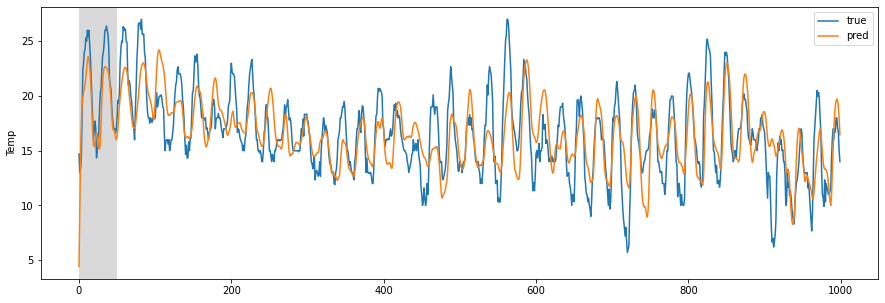

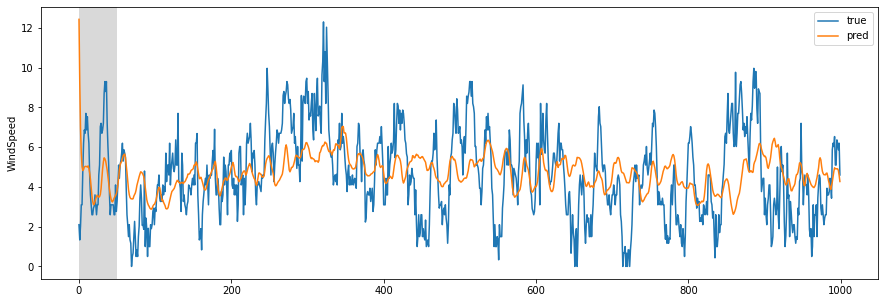

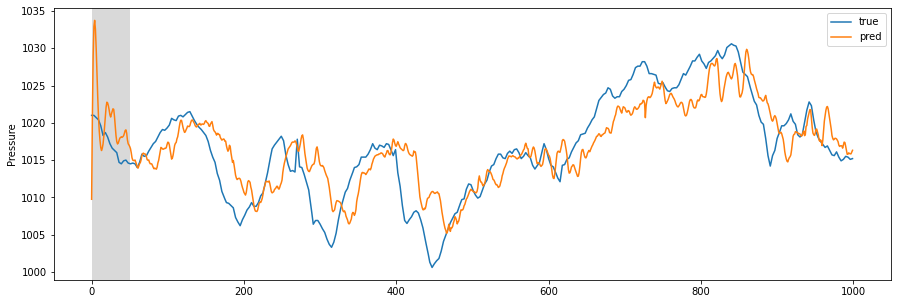

In [134]:
# on training data itself
plot_comparison(start_idx=100000, length=1000, train=True)

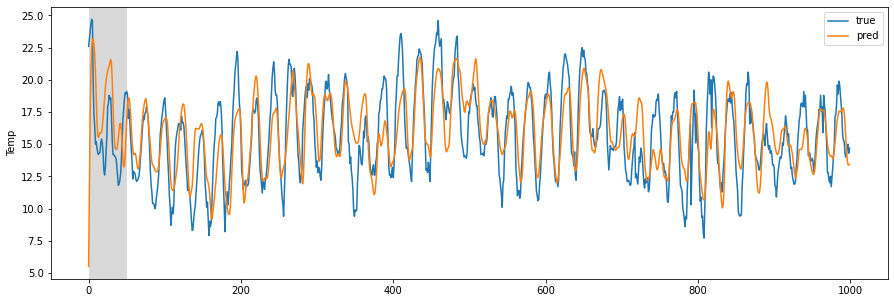

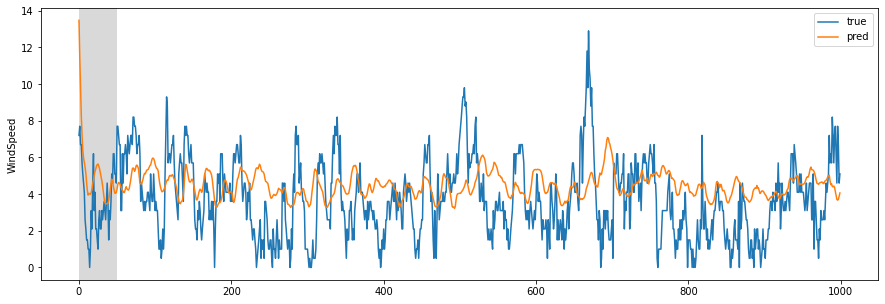

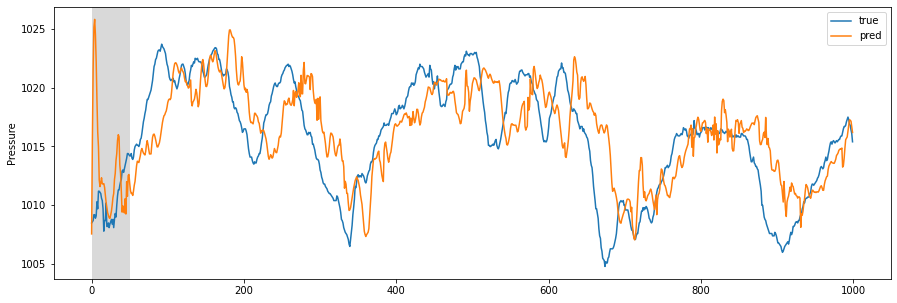

In [135]:
# on test set
plot_comparison(start_idx=200, length=1000, train=False)